# Prédiction de l'émission du CO2


Contexte: Depuis 2001, l’ADEME(Agence de l'Environnement et de la Maîtrise de l'Energie) acquiert tous les ans des données sur les émissions de polluants et les caractéristiques techniques des véhicules commercialisés en France auprès de l’Union Technique de l’Automobile du motocycle et du Cycle UTAC (en charge de l’homologation des véhicules avant leur mise en vente) en accord avec le ministère du développement durable.

Pour chaque véhicule, les données d’origine (transmises par l’Utac) sont les suivantes :

. les consommations de carburant

. les émissions de dioxyde de carbone (CO2)

. les émissions des polluants de l’air (réglementés dans le cadre de la norme Euro)

. l’ensemble des caractéristiques techniques des véhicules (gammes, marques, modèles, n° de CNIT, type   d’énergie ...)

L'objectif est de prédire les émissions de dioxyde de carbonne (CO2) des véhicules commercialisés en France en utilisant comme informations leurs caractéristiques techniques et leurs consommations en carburant. Différentes méthodes d'apprentissage automatique (Régression Linéaire, RandomForest, XGBoost) sont utilisés. Après une comparaison des performances de chacune d'elles, le meilleur modèle est choisi et déployé via une API(Application Programming Interface), FastAPI dans notre contexte. Cette API va permettre de rendre exploitable notre modèle par un utilisateur lambda qui pourra faire des prédictions en utilisant de nouvelles informations provennants de nouveaux véhicules. Notre API est ensuite conténeuriser sur Doker. 

La base de données que nous avons exploité pour ce projet est fournis par le site gouvernemental data.gouv.fr.


Source des données: https://www.data.gouv.fr/fr/datasets/emissions-de-co2-et-de-polluants-des-vehicules-commercialises-en-france/

# Dictionnaire des variables






 puiss_admin_98: la puissance administrative  
 
 puiss_max: la puissance maximale (en kW) 
 
 conso_urb: consommation urbaine de carburant  (en l/100km)
 
 conso_mixte: consommation extra urbaine de carburant  (en l/100km)
 
 co2: l'émission de CO2 (en g/km)   gramme par km
 
 masse_ordma_min: la masse en ordre de marche mini en kg
 
 masse_ordma_max: la masse en ordre de marche maxi en kg
 
 lib_mrq: La marque
 
 cod_cbr: type de carburant
 
 gamme: gamme
 
 
 

# Importation des données brutes et des bibliothèques

In [27]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge 
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import validation_curve
import warnings

from sklearn.base import BaseEstimator, TransformerMixin 
from sklearn.pipeline import Pipeline 
from sklearn.impute import SimpleImputer


data = pd.read_csv('data.csv', sep=';', decimal=',', encoding='ISO-8859-1')

data.head()


,co2,puiss_admin_98,puiss_max,conso_urb,conso_mixte,masse_ordma_min,masse_ordma_max,lib_mrq,gamme,cod_cbr
0,182.0,12,147.0,11.3,7.8,1505,1505,ALFA-ROMEO,MOY-SUPER,ES
1,186.0,12,147.0,11.5,8.0,1555,1555,ALFA-ROMEO,MOY-SUPER,ES
2,134.0,7,100.0,6.6,5.1,1565,1565,ALFA-ROMEO,MOY-SUPER,GO
3,134.0,7,100.0,6.6,5.1,1565,1565,ALFA-ROMEO,MOY-SUPER,GO
4,139.0,9,125.0,6.9,5.3,1565,1565,ALFA-ROMEO,MOY-SUPER,GO


Extraction de la base de données des variables continues ou quantitatives

In [28]:
df = data.select_dtypes(include=['int', 'float'])
df=df.astype(float)
df.head()

,co2,puiss_admin_98,puiss_max,conso_urb,conso_mixte,masse_ordma_min,masse_ordma_max
0,182.0,12.0,147.0,11.3,7.8,1505.0,1505.0
1,186.0,12.0,147.0,11.5,8.0,1555.0,1555.0
2,134.0,7.0,100.0,6.6,5.1,1565.0,1565.0
3,134.0,7.0,100.0,6.6,5.1,1565.0,1565.0
4,139.0,9.0,125.0,6.9,5.3,1565.0,1565.0


# Analyse exploratoire des données

In [29]:
# Vérifions les colonnes qui comportes des données manquantes dans notre dataset
df.isnull().any()


co2                 True
puiss_admin_98     False
puiss_max          False
conso_urb           True
conso_mixte         True
masse_ordma_min    False
masse_ordma_max    False
dtype: bool

Pourcentage de valeurs manquantes pour chaque variables de notre dataFrame

In [30]:

missing_values = df.isnull().sum()
percentage_missing = (missing_values / len(df)) * 100
print(percentage_missing)


co2                0.061769
puiss_admin_98     0.000000
puiss_max          0.000000
conso_urb          0.078119
conso_mixte        0.061769
masse_ordma_min    0.000000
masse_ordma_max    0.000000
dtype: float64


Statistiques descriptive des variables

In [31]:

df.describe()

,co2,puiss_admin_98,puiss_max,conso_urb,conso_mixte,masse_ordma_min,masse_ordma_max
count,55010.000000,55044.000000,55044.000000,55001.000000,55010.000000,55044.000000,55044.000000
mean,201.707035,10.551504,118.984916,9.575919,7.764832,2102.104553,2341.021801
std,33.976278,5.126021,45.417430,2.082148,1.381668,294.731715,424.067895
min,13.000000,1.000000,10.000000,0.000000,0.600000,825.000000,825.000000
25%,193.000000,9.000000,100.000000,8.800000,7.300000,1982.000000,2075.000000
50%,205.000000,10.000000,120.000000,9.400000,7.800000,2076.000000,2355.000000
75%,216.000000,10.000000,120.000000,10.200000,8.300000,2246.000000,2709.000000
max,572.000000,81.000000,585.000000,41.099998,24.500000,2760.000000,3094.000000


Représentation des boxplots des distributions des variables sans les outliers 

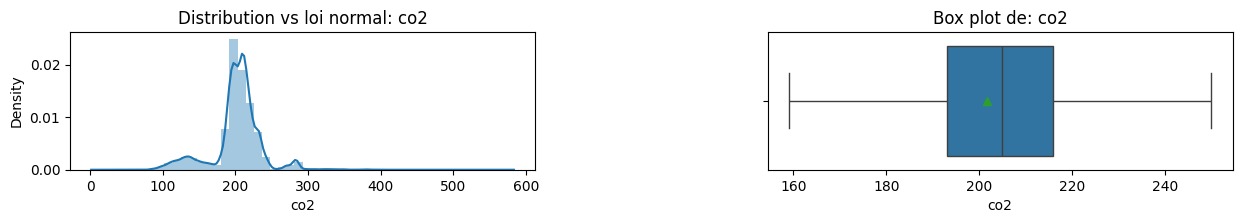

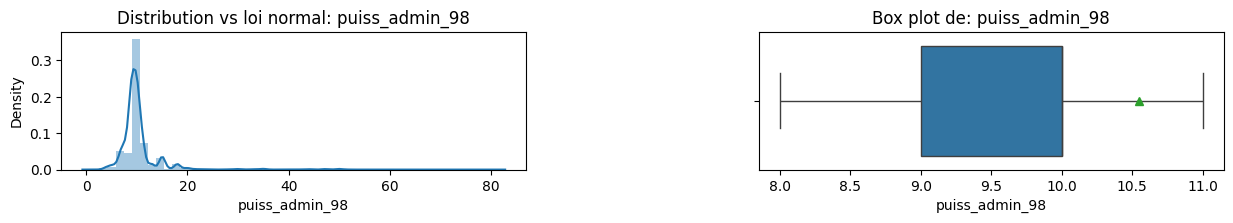

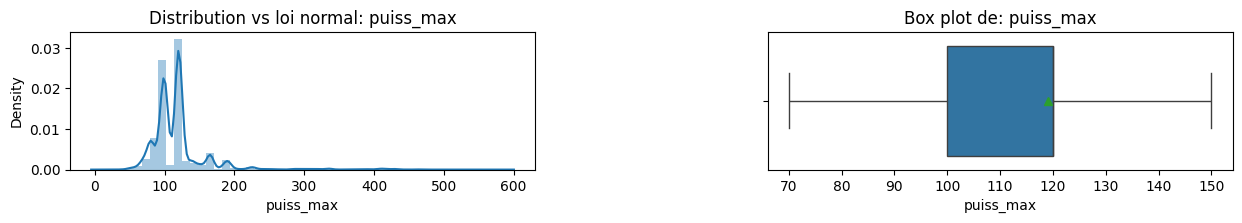

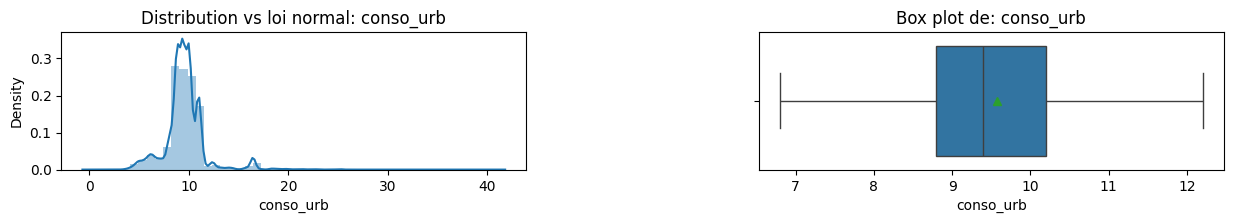

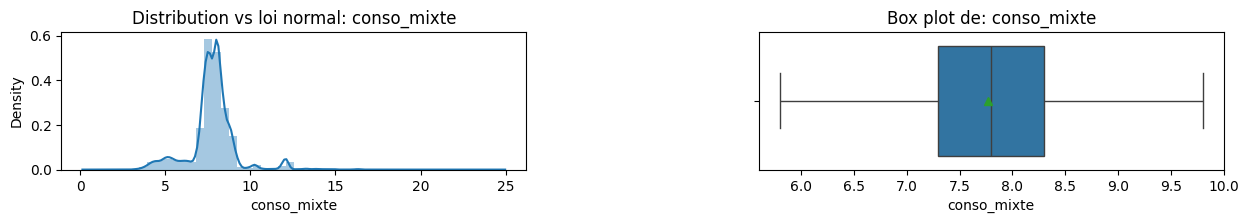

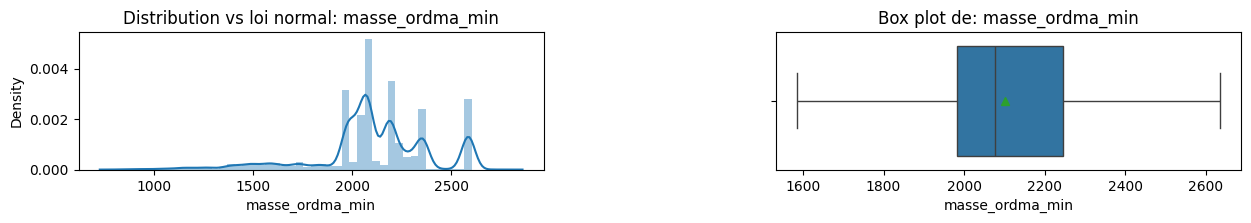

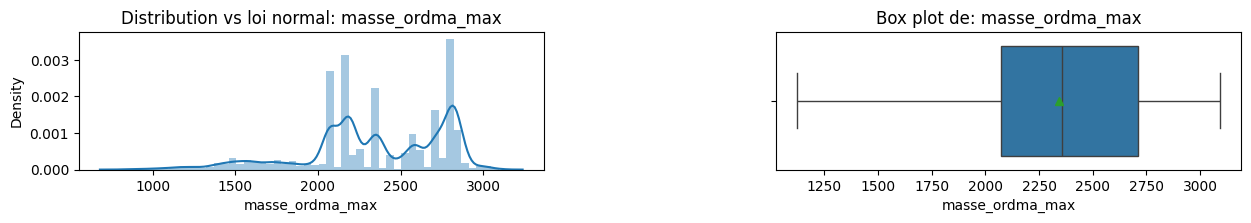

In [32]:

plt.rcParams["figure.figsize"] = [15,5]
grid = plt.GridSpec(2,2 , wspace=0.5, hspace=0.8)
for col in df.select_dtypes( include = ['float', 'int']).columns.to_list():
    plt.figure()
    ax0 = plt.subplot(grid[0, 0:1])
    ax0= sns.distplot(df[col], kde =True)
    ax0.set_title("Distribution vs loi normal: {}" .format(col), fontsize = 12)
    ax1 = plt.subplot(grid[0, 1:])
    ax1= sns.boxplot(data = df,  x = df[col], showfliers =False, showmeans =True)
    ax1.set_title("Box plot de: {}" .format(col), fontsize = 12)
warnings.filterwarnings("ignore")


COMMENTAIRE: Nous constatons que les distributions des différentes variables de nos données ne suivent pas une loi normale. Aussi, plus de la moitiè des véhicules émettent plus de 200 g/km de CO2.

Représentation des boxplots des distributions des variables avec les outliers

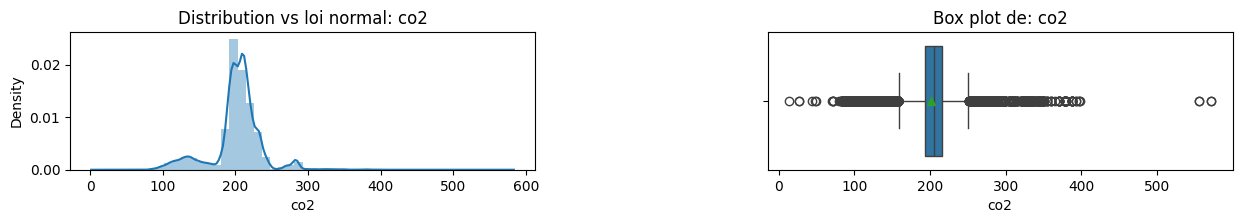

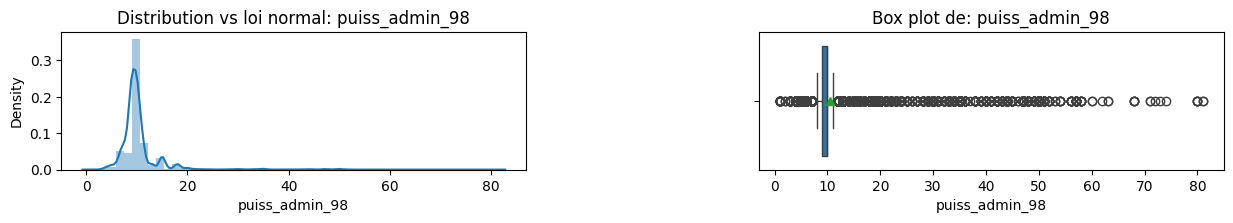

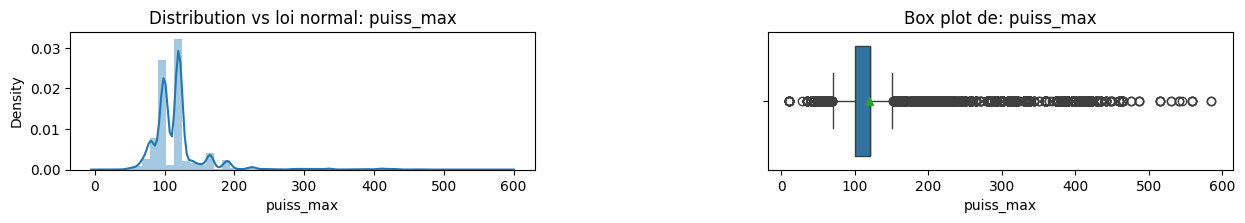

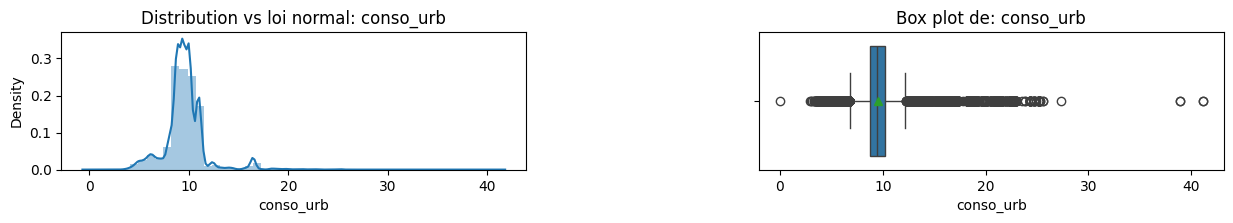

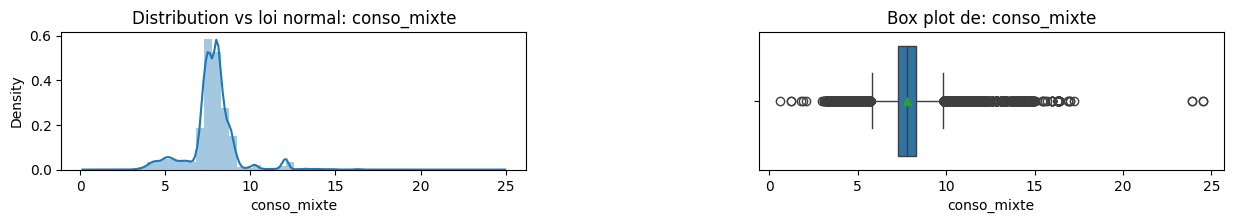

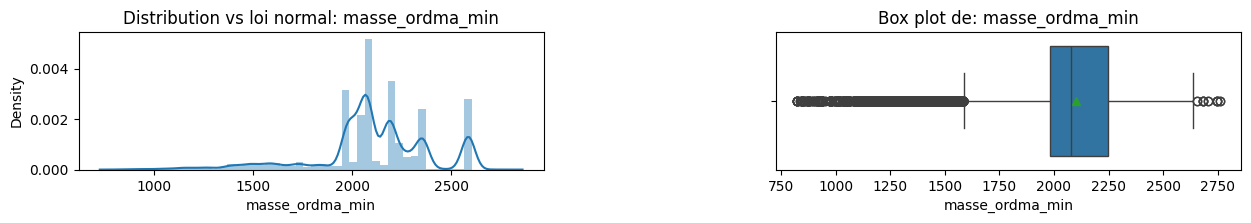

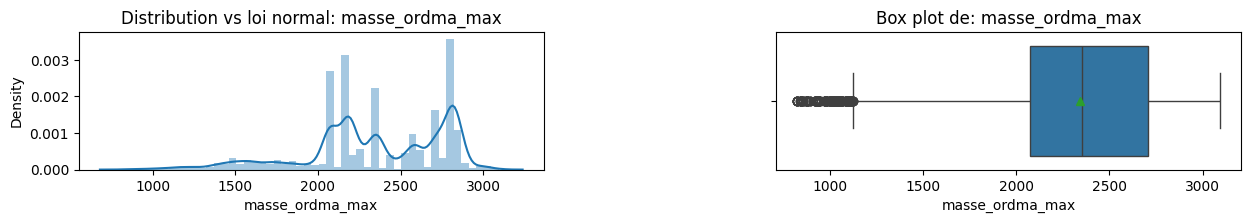

In [33]:
plt.rcParams["figure.figsize"] = [15,5]
grid = plt.GridSpec(2,2 , wspace=0.5, hspace=0.8)
for col in df.select_dtypes( include = ['float', 'int']).columns.to_list():
    plt.figure()
    ax0 = plt.subplot(grid[0, 0:1])
    ax0= sns.distplot(df[col], kde =True)
    ax0.set_title("Distribution vs loi normal: {}" .format(col), fontsize = 12)
    ax1 = plt.subplot(grid[0, 1:])
    ax1= sns.boxplot(data = df,  x = df[col], showfliers =True, showmeans =True)
    ax1.set_title("Box plot de: {}" .format(col), fontsize = 12)
warnings.filterwarnings("ignore")

Nous constatons la présence de valeurs abbérantes dans toute les variables de nos données. La présence de ces valeurs abbérantes est tout à fait logique compte tenue des différences individuelles de nos données (différences entre véhicules) qui peuvent être élevées. En effet, les caractéristiques techniques, la consommation en carburant et la pollution d'un véhicule de haute gamme peut être assez éloigné de la moyennes des mêmes caractéristique sur les véhicules de gammes moyens ou de basses gammes.    

Etant donnée la présence de ces valeurs abbérantes dans les colonnes comportants des valeurs manquantes,
nous avons choisi de remplacer les valeurs manquantes par la médiane compte tenue du fait que celui-ci est
moins sensible aux valeurs extrèmes.

Moyenne d'émission de Co2 par marque

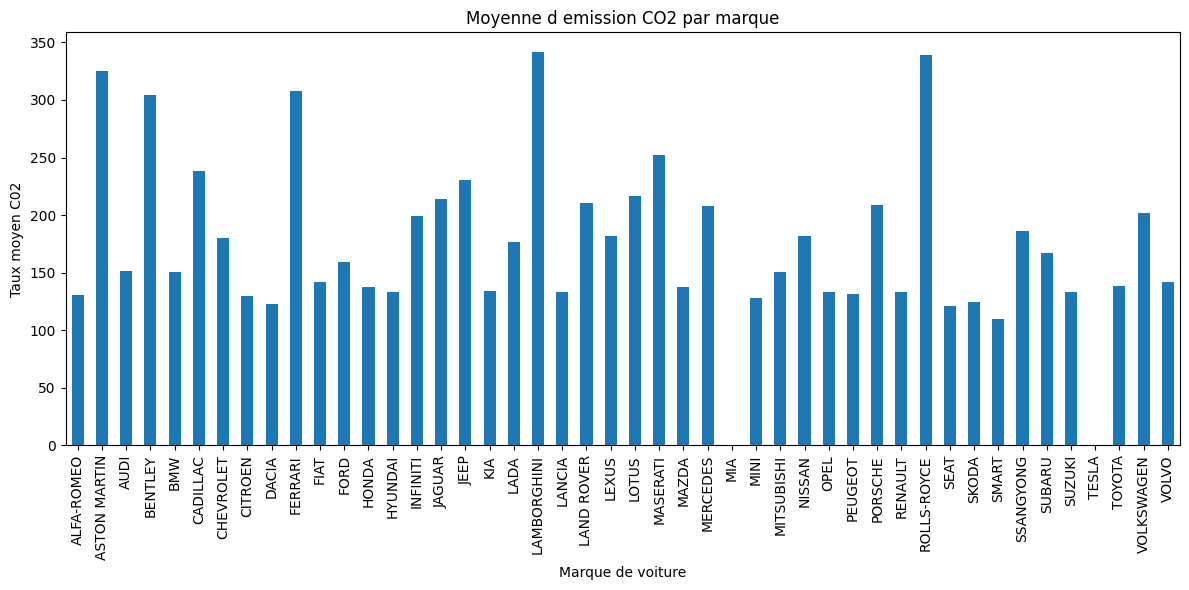

In [34]:

mean_by_modalite = data.groupby('lib_mrq')['co2'].mean()

# Create the bar plot
plt.figure(figsize=(12, 6))  # Adjust the figure size if needed
mean_by_modalite.plot(kind='bar')

# Set the plot title and axis labels
plt.title('Moyenne d emission CO2 par marque')
plt.xlabel('Marque de voiture')
plt.ylabel('Taux moyen C02')

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=90)

# Display the plot
plt.tight_layout()
plt.show()


Emission de Co2 en fonction de la gamme

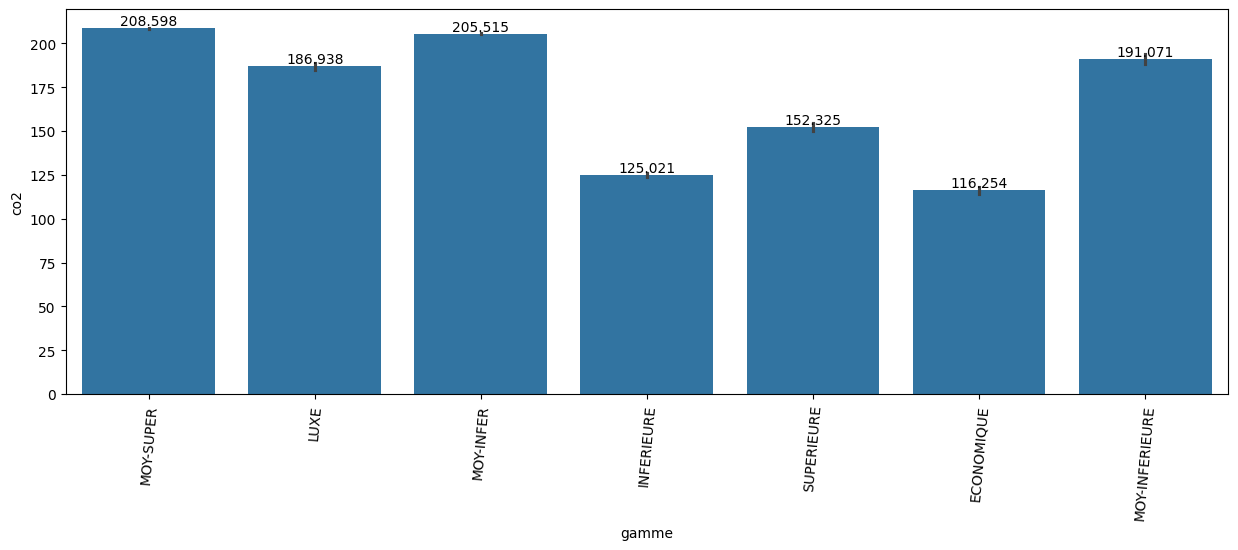

In [35]:
ax = sns.barplot(y = data['co2'], x = data['gamme'], data = data)
plt.xticks(rotation = 85)
for i in ax.containers:
    ax.bar_label(i,)
    
plt.show()

Commentaire: Un premier constat consiste à affirmer que les vehicules de gamme: Luxe; MOY-SUPER et MOY-INFER polluent plus que les gammes Inferieures ou encore economiques.

Nuages de points entre notre target(CO2) et nos features(autres variables) 

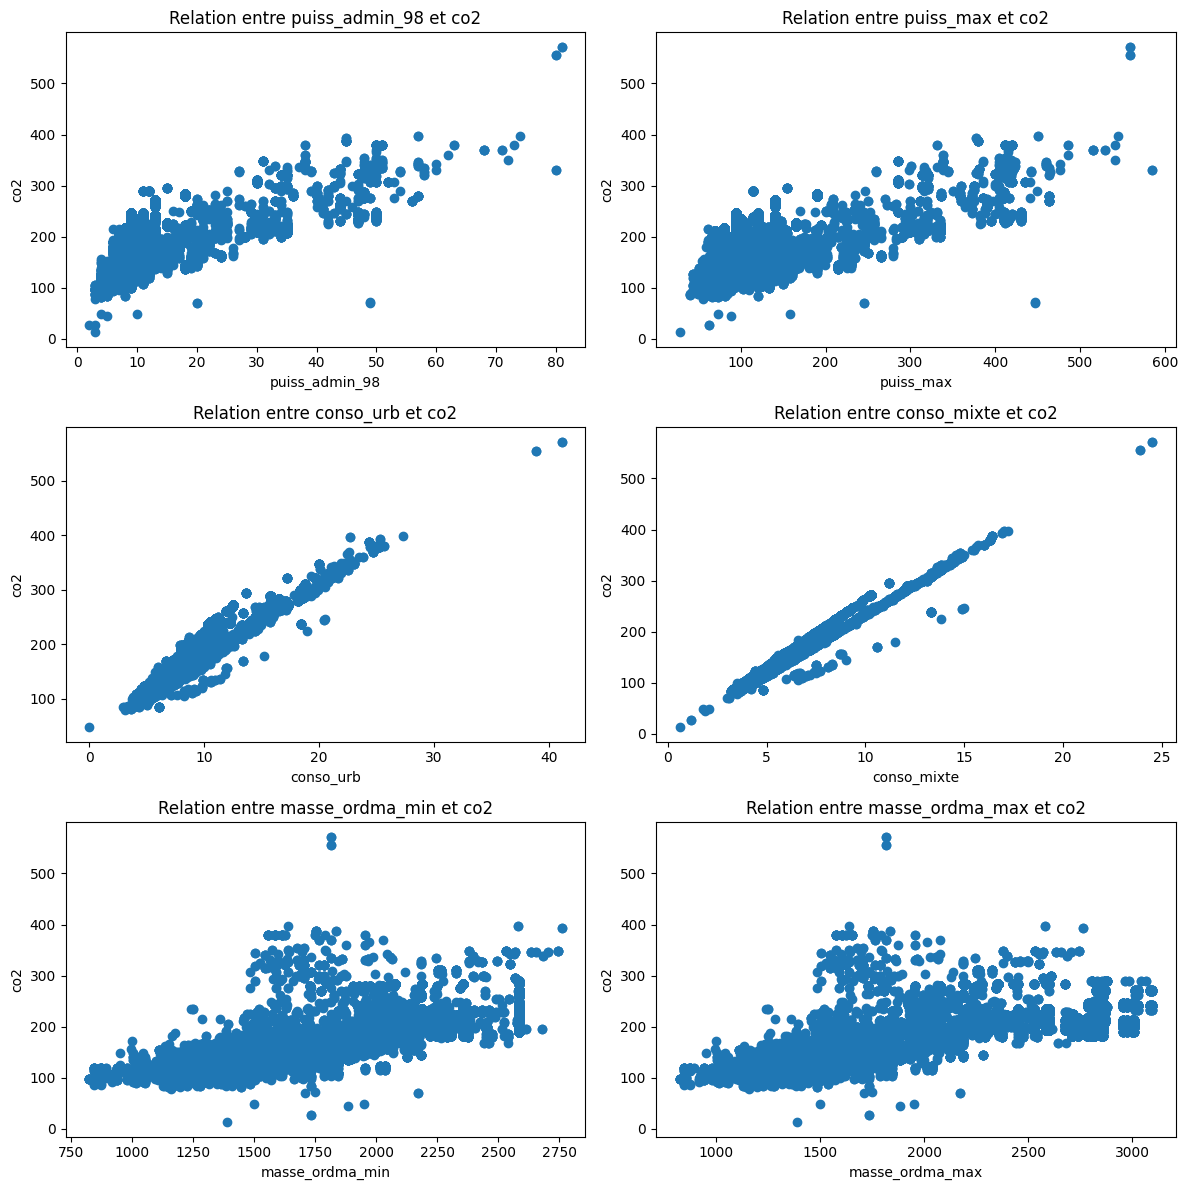

In [36]:
import matplotlib.pyplot as plt
import pandas as pd


y_var = 'co2'
x_vars = df.columns.drop(y_var)

n_rows = len(x_vars) // 2 + len(x_vars) % 2
n_cols = 2

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, n_rows*4)) 
axs = axs.flatten()

for i, x_var in enumerate(x_vars):
    axs[i].scatter(df[x_var], df[y_var])
    axs[i].set_title(f'Relation entre {x_var} et {y_var}')
    axs[i].set_xlabel(x_var)
    axs[i].set_ylabel(y_var)

for ax in axs[i+1:]:
    ax.axis('off')

plt.tight_layout()  
plt.show()


Commentaire: On constate une relation linéaire forte (équivalent à une forte corrélation) entre d'une part les variables co2 et conso_mixte et d'autre part les variables co2 et conso_urb.

 Matrice de corrélation entre les variables

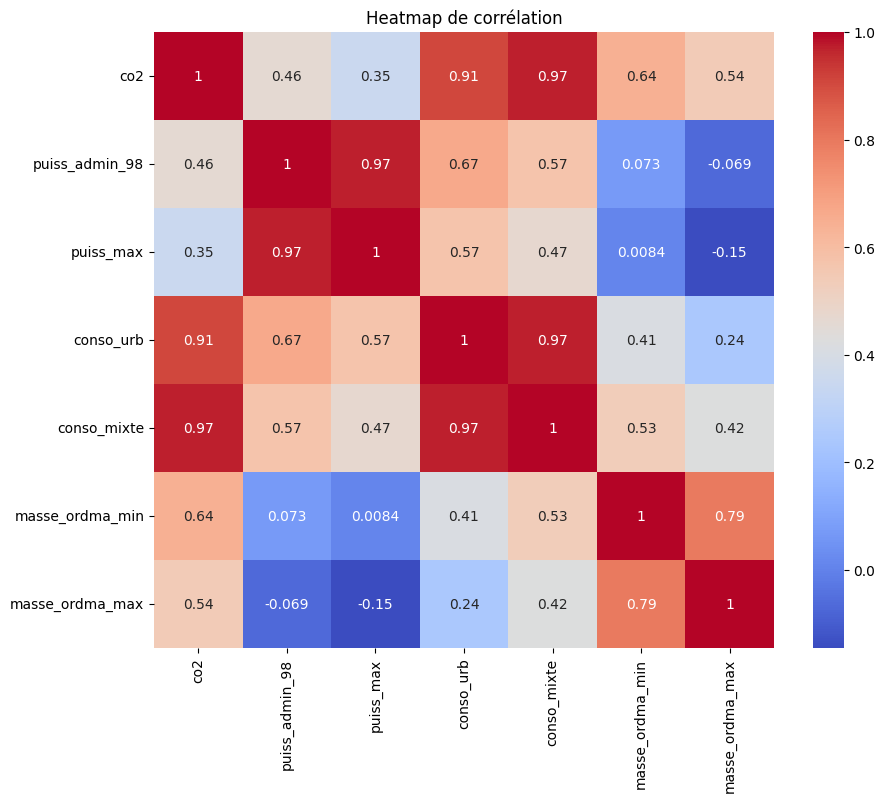

In [11]:

# Calculer la matrice de corrélation
corr_matrix = df.corr()

# Tracer le heatmap de corrélation
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, ax=ax)
plt.title('Heatmap de corrélation')
plt.show()


Commentaire: D'après la matrice de corrélation, il existe une forte corrélation entre CO2 et conso_urb, entre CO2 et conso_mixte, entre puiss_admin_98 et puiss_max puis entre conso_urb et conso_mixte. Cette forte corrélation entre certaines variables explicatives peut entrainer une multicolinéarité. Il y'aura autrement dit, un problème de redondance d'information dans  notre modèle. Parmis les couples de variables explicatives corrélés, nous choisisons de supprimer la variable la moins corrélé avec le CO2. Suivant cette logique, nous supprimons les variables Conso_urb et puiss_max.

Nouvelle matrice de corrélation

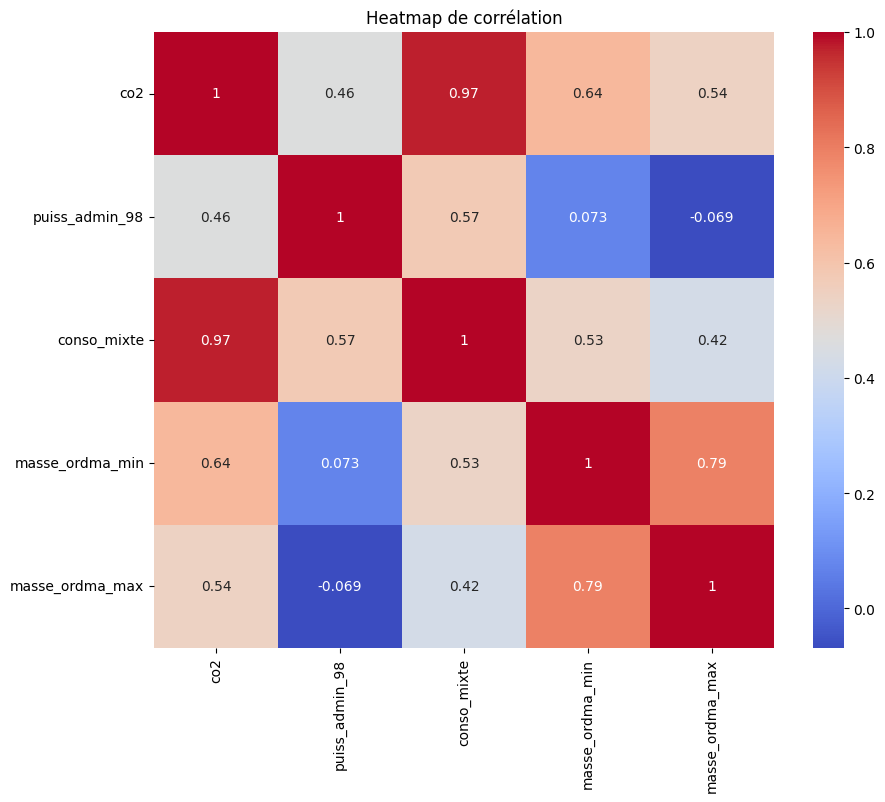

In [12]:
df=df.drop(['conso_urb','puiss_max'],axis=1)

# Calculer la matrice de corrélation
corr_matrix = df.corr()

# Tracer le heatmap de corrélation
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, ax=ax)
plt.title('Heatmap de corrélation')
plt.show()

# Modélisation de l'emission de CO2

Division des données en données d'entrainement et en données de test. Nous utiliserons 80% pour l'entrainement du modèle et 20% pour le test.

In [13]:
# Target du modèle
Y = df['co2'].fillna(df['co2'].mean())

#  Features du modèle
X = df.drop('co2', axis=1)

train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size = 0.2, random_state = 20)

Pipeline de Preprocessing des données: Standardisation et imputation des valeurs manquantes par la médiane

In [14]:

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline 

colonnes=X.columns

data_pipeline = Pipeline([('StandardScaler', StandardScaler()), 
                            ('imputer', SimpleImputer(strategy='median')) 
                            ]) 

preprocessor= make_column_transformer((data_pipeline, colonnes))
#numeric_pipeline.fit(X) 
#new_df = numeric_pipeline.transform(test[{'Age', 'Fare'}]) 

Modélisation par la LinearRegression

In [15]:

# Pipeline du modèle de régression linéaire
model = make_pipeline(preprocessor,LinearRegression())  
# Entraînement du modèle 
model.fit(train_X, train_y)
# Prédiction sur les données de test
y_test_pred = model.predict(test_X)

# Calcule de l'erreur quadratique moyenne
rmse = np.sqrt(metrics.mean_squared_error(test_y, y_test_pred))
print(" Root Mean Squared Error:", rmse)
# Calcule du coefficient de détermination R2
r2 = r2_score(test_y, y_test_pred)
print("R2 :", r2)


 Root Mean Squared Error: 5.740531470881124
R2 : 0.9708047661386702


Visualisation de la l'ajustement de la LinearRegression à nos données

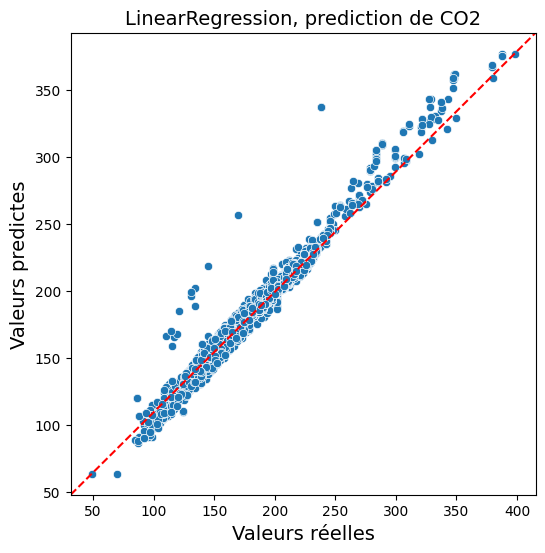

In [16]:
fig, ax = plt.subplots(figsize = (6,6))
sns.scatterplot(x = test_y, y = y_test_pred)
ax.plot([0,1], [0,1], ls ='--', c = 'red', transform = ax.transAxes)
plt.xlabel("Valeurs réelles", fontsize = 14)
plt.ylabel("Valeurs predictes", fontsize = 14)
ax.set_title("LinearRegression, prediction de CO2", fontsize = 14)
plt.show()

Commentaire: On constate à travers la figure que le modèle s'ajuste bien à nos données avec une variation du CO2 qui est expliquée à plus de 97% par notre modèle.

Modélisation par un modèle Random Forest

In [17]:
from sklearn.ensemble import RandomForestRegressor

model_RandmF = make_pipeline(preprocessor,RandomForestRegressor(n_estimators=20, max_depth=4, random_state=42)) 
model_RandmF.fit(train_X, train_y)
pred_y = model_RandmF.predict(test_X)

rmse = np.sqrt(metrics.mean_squared_error(test_y, pred_y))
print("Root Mean Squared Error:", rmse)
r2 = r2_score(test_y, pred_y)
print("R2:", r2)


Root Mean Squared Error: 5.975681851716042
R2: 0.9683639182751599


Visualisation de l'ajustement du RandomForestRegression à nos données

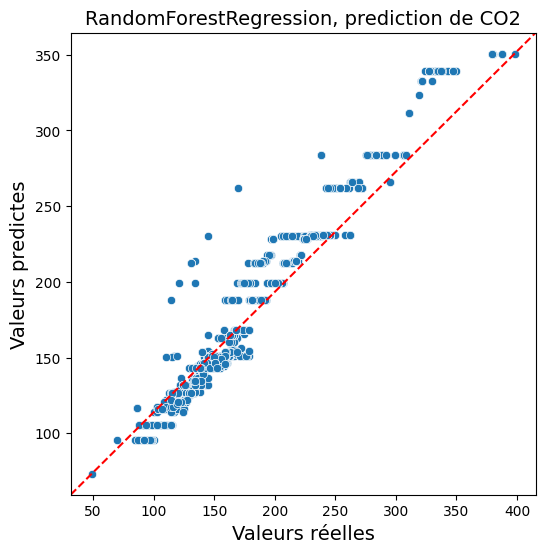

In [18]:
fig, ax = plt.subplots(figsize = (6,6))
sns.scatterplot(x = test_y, y = pred_y)
ax.plot([0,1], [0,1], ls ='--', c = 'red', transform = ax.transAxes)
plt.xlabel("Valeurs réelles", fontsize = 14)
plt.ylabel("Valeurs predictes", fontsize = 14)
ax.set_title("RandomForestRegression, prediction de CO2", fontsize = 14)
plt.show()

COMMENTAIRE: On constate à travers la figure que le modèle s'ajuste bien à nos données mais moins bien que la LinearRegression.

Modélisation par l'algorithme XGBoost

In [19]:


import xgboost 
model_xgboost = make_pipeline(preprocessor,xgboost.XGBRegressor(max_depth=5, subsample=0.7,  
sampling_method='uniform', seed=42, n_estimators=20))

model_xgboost.fit(train_X, train_y) 
pred_y = model_xgboost.predict(test_X) 

rmse = np.sqrt(metrics.mean_squared_error(test_y, pred_y))
print(" Root Mean Squared Error:", rmse)
r2 = r2_score(test_y, pred_y)
print("R2 :", r2)

 Root Mean Squared Error: 1.9995339198203772
R2 : 0.996457863397635


 Visualisation de l'ajustement du XGBoostRegression à nos données

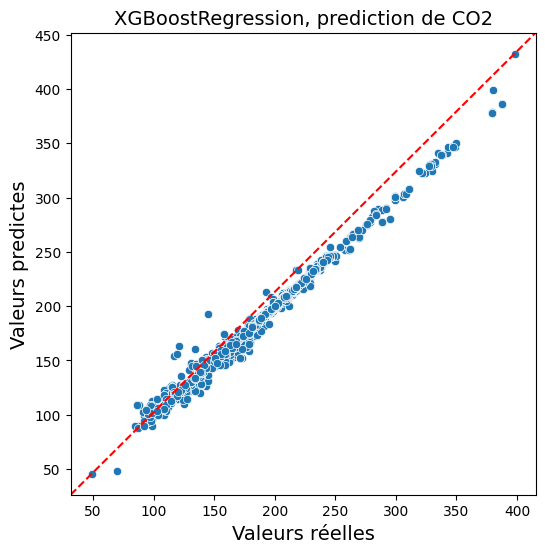

In [20]:
fig, ax = plt.subplots(figsize = (6,6))
sns.scatterplot(x = test_y, y = pred_y)
ax.plot([0,1], [0,1], ls ='--', c = 'red', transform = ax.transAxes)
plt.xlabel("Valeurs réelles", fontsize = 14)
plt.ylabel("Valeurs predictes", fontsize = 14)
ax.set_title("XGBoostRegression, prediction de CO2", fontsize = 14)
plt.show()

COMMENTAIRE: On constate à travers la figure que le modèle s'ajuste beaucoup mieux à nos données que les deux précédents avec une variation du CO2 qui est expliquée à plus de 99% par notre modèle. Des trois modèles utilisés, l'algorithme XGBoost Régressor est de loin la plus performante avec Le RMSE le plus petit et le R2 le plus grand.

Courbe d'apprentissage de l'algorithme XGBoost

In [21]:


def plot_learning_curve(estimator, X, y, param_name, param_range):
    train_scores, test_scores = validation_curve(estimator, X, y, param_name=param_name, param_range=param_range,
                                                 scoring='neg_root_mean_squared_error', cv=None)
    
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure()
    plt.title('Learning Curve')
    plt.xlabel('Value of ' + param_name)
    plt.ylabel('Negative Root Mean Squared Error')
    plt.grid()
    
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color='b')
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='r')
    
    plt.plot(param_range, train_scores_mean, 'o-', color='b', label='Training Error')
    plt.plot(param_range, test_scores_mean, 'o-', color='r', label='Validation Error')
    
    plt.legend(loc='best')
    return plt



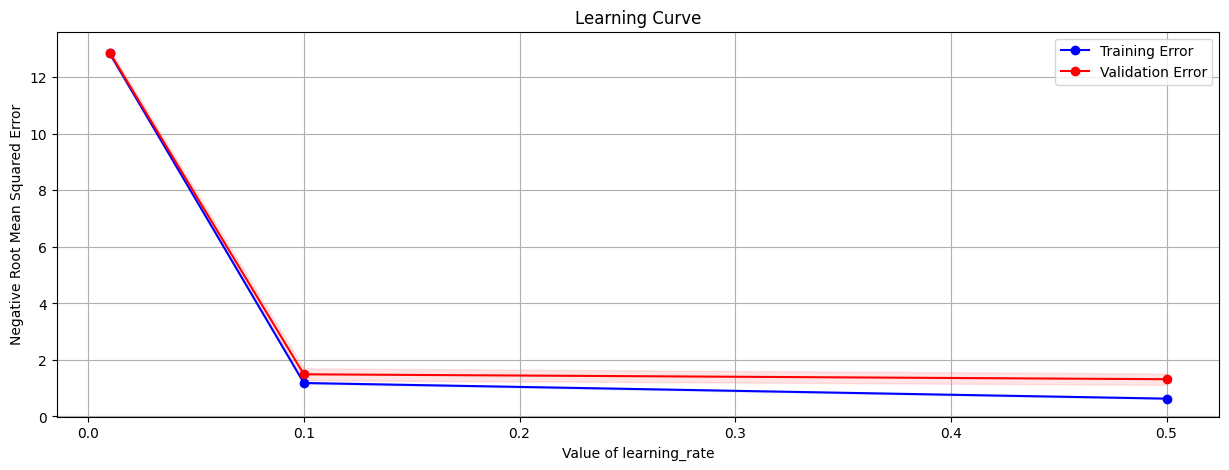

In [22]:
import xgboost
from xgboost import XGBRegressor
estimator = XGBRegressor()  
param_name= 'learning_rate'
param_range= [0.01, 0.1, 0.5]

plot_learning_curve(estimator, train_X, train_y, param_name, param_range)
plt.show()

Commentaire: Nous pouvons constater que notre modèle se généralise assez bien sur nos données de tests vu la convergence conjointe des learning curve d'apprentissage et de validation.

Conclusion: Nous constatons au vue des performances de nos modèles que le modèle XGBoost est le meilleure parmis les deux autres(Régression Linéaire et Random Forest) car il a le plus petite erreur de prévision (RMSE) et le plus grand R2.

Prédiction avec de nouvelles valeurs

In [23]:

data = [[10, 7.800000191, 1303, 1405]]

data=pd.DataFrame(data, columns=colonnes)

prev = model.predict(data)

print(prev)


[188.79599947]


Sauvégarde du meilleur modèle (XGBoost) pour déploiement

In [186]:

from joblib import dump
dump(model_xgboost, 'bestModel.joblib')

['bestModel.joblib']